# OkCupid Data

The OkCupid dataset is very interesting and has many useful elements, but the data have some inherent issues that were fascinating to consider while trying to formulate good questions around the data.

First I'll load the packages I'll use and import the data.

I'll quickly check what the column names for the dataset are and how many rows I'm working with

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df = pd.read_csv('profiles.csv')

print(df.columns)
print(len(df))
print(df.head())

Index([u'age', u'body_type', u'diet', u'drinks', u'drugs', u'education',
       u'essay0', u'essay1', u'essay2', u'essay3', u'essay4', u'essay5',
       u'essay6', u'essay7', u'essay8', u'essay9', u'ethnicity', u'height',
       u'income', u'job', u'last_online', u'location', u'offspring',
       u'orientation', u'pets', u'religion', u'sex', u'sign', u'smokes',
       u'speaks', u'status'],
      dtype='object')
59946
   age       body_type               diet    drinks      drugs  \
0   22  a little extra  strictly anything  socially      never   
1   35         average       mostly other     often  sometimes   
2   38            thin           anything  socially        NaN   
3   23            thin         vegetarian  socially        NaN   
4   29        athletic                NaN  socially      never   

                           education  \
0      working on college/university   
1              working on space camp   
2     graduated from masters program   
3      working on col

In [2]:
# Here is the function I'll be using for all scores:

def model_scores(train_labels, train_predictons, test_labels, test_predictions, model_to_score):
    
    train_accuracy = accuracy_score(train_labels, train_predictions)
    test_accuracy = accuracy_score(test_labels, test_predictions)
    
    train_precision = precision_score(train_labels, train_predictions, average='macro')
    test_precision = precision_score(test_labels, test_predictions, average='macro')
    
    train_recall = recall_score(train_labels, train_predictions, average='macro')
    test_recall = recall_score(test_labels, test_predictions, average='macro')

    print('Training data accuracy: ' + str(train_accuracy) + '; Test data accuracy: ' + str(test_accuracy))
    print('Training data precision: ' + str(train_precision) + '; Test data precision: ' + str(test_precision))
    print('Training data recall: ' + str(train_recall) + '; Test data recall: ' + str(test_recall) + '\n')

So it looks like I'll be dealing with a lot of categorical data. I'll have to codify these before performing any analyses. In the meantime, I want to get a sense of what kind of biases we have in the data. 

For simplicity, I'll only plot a few of the features this way

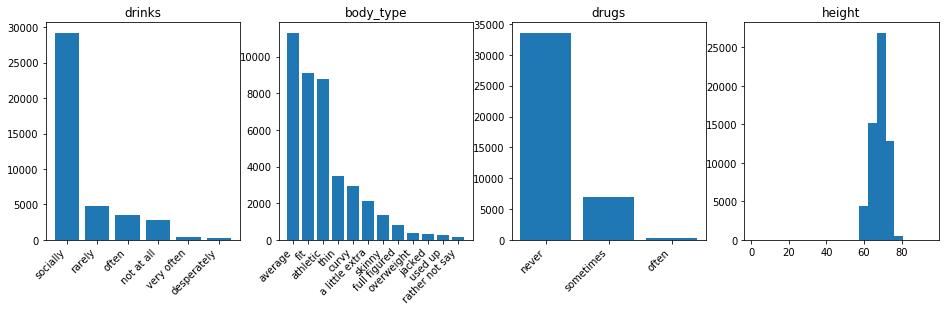

In [3]:
df_plot = df.dropna(axis=0, subset=['drinks', 'body_type', 'drugs'])[['drinks', 'body_type', 'drugs']]

fig = plt.figure(figsize=[16, 4])

for i in range(len(df_plot.columns)):
    
    column_name = list(df_plot.columns)[i]
    
    ax = fig.add_subplot(1,4,i+1)
    ax.bar(list(df_plot[column_name].value_counts().index), list(df_plot[column_name].value_counts()))
    
    plt.xticks(rotation=45, horizontalalignment='right')
    plt.title(column_name)
    
ax = fig.add_subplot(1, 4, 4)
ax.hist(df.dropna(axis=0, subset=['height'])['height'], bins=20)
plt.title('height')

plt.show()

Several of the features of the data appear to have pretty heavy biases for certain categories. This could make it difficult for classification methods, as there are fewer examples for certain categories of certain features.

Also, there seem to be some outliers in height which skew the data. Those should be removed before analysis.

But given how much data there was about health and lifestyle, I wanted to see how well certain lifestyle features correlate with the self-reported health status. 
In other words, are certain types of lifestyles good at predicting what someone's physique might be?

As a proxy for this status, I chose to look at body_type as the target.

## Does lifestyle (ie. diet, drinking, activity level, etc.) predict body type?

The lifestyle features I chose to initially look at for this classification model were:

* diet
* drinks
* drugs
* smokes
* height
* smokes
* income
* age
* body_type
* how_active (generated by searching essays for keywords)

First, I needed to combine and read through essays to look for how active the users seem to be. I counted the number of times that certain physical activity keywords appeared in users' essays as a measure of "how active" the user is.

In [4]:
# First, I had to combine all of the essays into one (this was taken from the example provided):

essay_cols = ["essay0", "essay1", "essay2", "essay3", "essay4", "essay5", "essay6", "essay7", "essay8", "essay9"]

all_essays = df[essay_cols].replace(np.nan, '', regex=True)
df['all_essays'] = all_essays[essay_cols].apply(lambda x: ' '.join(x), axis=1)

Next, I needed to codify all of my categorical health categories and remove outliers from my continuous feature, height.

In [5]:
# Here, I prepare to codify all of the features of interest. First, I generated a separate df for these analyses:

df_health = df.dropna(axis=0, subset=['body_type', 'diet', 'all_essays', 'height', 
                                      'drinks', 'smokes', 'drugs', 'income', 'age'])[['body_type', 'diet', 'all_essays', 'height',
                                                                     'drinks', 'smokes', 'drugs', 'income', 'age']]

# I want to know how many rows made it through the dropna function:

print(len(df_health))

# Now all of the values that will be used to index and codify the features:

body_categories = ['rather not say', 'used up', 'overweight', 'full figured', 'a little extra', 'curvy',
                   'average', 'thin', 'skinny', 'fit', 'athletic', 'jacked']

diets = ['strictly other', 'other', 'mostly other', 
         'strictly vegan', 'vegan', 'mostly vegan',
         'strictly halal', 'halal', 'mostly halal', 
         'strictly kosher', 'kosher', 'mostly kosher', 
         'strictly vegetarian', 'vegetarian', 'mostly vegetarian', 
         'strictly anything', 'anything', 'mostly anything', ]

drinks_categories = ['not at all', 'rarely', 'socially', 'often', 'very often', 'desperately']

smokes_categories = ['no', 'trying to quit', 'sometimes', 'when drinking', 'yes']

drugs_categories = ['never', 'sometimes', 'often']

25202


In [6]:
# Here I generate the new coded columns:

df_health['body_code'] = df_health.body_type.apply(lambda x: body_categories.index(x))

df_health['diet_code'] = df_health.diet.apply(lambda x: diets.index(x))

df_health['drinks_code'] = df_health.drinks.apply(lambda x: drinks_categories.index(x))

df_health['smokes_code'] = df_health.smokes.apply(lambda x: smokes_categories.index(x))

df_health['drugs_code'] = df_health.drugs.apply(lambda x: drugs_categories.index(x))

In [7]:
# Here are the keywords I'll be searching for in the essays to get some sense of whether a person is active or not

sports = ['run', 'running', 'cycling', 'cycle', 'bike', 'swimming', 'swim',
          'climbing', 'climb', 'rowing', 'row', 'surfing', 'surf', 'work-out',
          'gym', 'workout', 'exercise', 'exercising', 'work out', 'working out', 'active',
          'keep active', 'play sports', 'playing sports', 'hockey', 'soccer', 'football',
          'basketball', 'tennis', 'rugby', 'physical activity', 'keep active', 'keeping active', 'kayaking', 
          'kayak', 'hiking', 'hike', 'sporty', 'athletic', 'yoga', 'lifting weights', 'weight training',
          'cross-fit', 'crossfit', 'staying fit', 'keep fit', 'stay fit', 'keep fit']

# I'll count the number of times the keywords appear in each essay as a measure of "how active" a person is:

df_health['how_active'] = df_health.all_essays.apply(lambda x: sum([word in x for word in sports]))

In [8]:
# Here I'll remove outliers from the height and income feature column:

df_health = df_health[(df_health.height > 55) & (df_health.height < 85)] # This gives us a range of people 4.5ft-7ft

In [9]:
# I want to see if any of the data correlate with body_code:

df_health.corr()

,height,income,age,body_code,diet_code,drinks_code,smokes_code,drugs_code,how_active
height,1.000000,0.066656,-0.046140,0.176691,0.015945,0.033913,0.045167,0.075849,0.025638
income,0.066656,1.000000,-0.005441,0.013840,-0.047976,0.051081,0.046488,0.080860,-0.003786
age,-0.046140,-0.005441,1.000000,-0.005729,-0.022533,-0.112718,-0.174671,-0.167099,0.080486
body_code,0.176691,0.013840,-0.005729,1.000000,0.002301,0.011751,-0.100870,-0.058701,0.203706
diet_code,0.015945,-0.047976,-0.022533,0.002301,1.000000,0.084314,-0.014296,-0.054465,-0.036391
drinks_code,0.033913,0.051081,-0.112718,0.011751,0.084314,1.000000,0.171727,0.217139,-0.023771
smokes_code,0.045167,0.046488,-0.174671,-0.100870,-0.014296,0.171727,1.000000,0.362938,-0.135562
drugs_code,0.075849,0.080860,-0.167099,-0.058701,-0.054465,0.217139,0.362938,1.000000,-0.048661
how_active,0.025638,-0.003786,0.080486,0.203706,-0.036391,-0.023771,-0.135562,-0.048661,1.000000


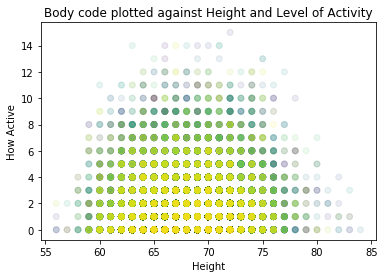

In [10]:
# Just to get an idea of whether we can already see some differentiated groups:

plt.scatter(df_health['height'], df_health['how_active'], c=range(len(df_health['body_code'])), alpha=0.1)
plt.xlabel('Height')
plt.ylabel('How Active')
plt.title('Body code plotted against Height and Level of Activity')
plt.show()

From the correlation table, it seems like height and "how_active" correlate the best with our body_code, so I'll try those features first.
I'll start by generating a training and test set for analysis

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Now to scale the data for analysis:

columns = ['how_active', 'smokes_code', 'height']
scaler = MinMaxScaler()
scaler.fit(df_health[columns])

KN_features = pd.DataFrame(scaler.transform(df_health[columns]), columns=columns)

train_data, test_data, train_labels, test_labels = train_test_split(KN_features, df_health['body_code'], 
                                                                    test_size=0.2, random_state=7)

/Applications/miniconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


I've chosen K Nearest Neighbors classifier for a first pass at the analysis. This is going to predict what someone's 'body_code' is based on the class of the data that is nearest to my test data points in the feature space.

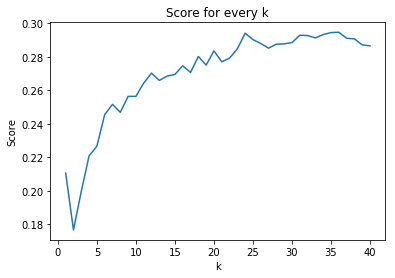

35


In [12]:
# Now I'll see what the best k is for the nearest neighbors analysis by testing different values and generating
# the results from scoring the test data set:

features = columns
scores = []

for i in range(1, 41):
    
    classifier = KNeighborsClassifier(n_neighbors=i, weights='distance')
    classifier.fit(train_data[features], train_labels)
    
    scores.append(classifier.score(test_data[features], test_labels))

plt.plot(range(1, 41), scores)
plt.xlabel('k')
plt.ylabel('Score')
plt.title('Score for every k')
plt.show()

ideal_k = scores.index(max(scores))

print(ideal_k)

In [13]:
# Now I'll see how well our classifier did for each category of body_type:

k = 25

classifier = KNeighborsClassifier(n_neighbors=k, weights='distance')
classifier.fit(train_data[features], train_labels)

train_predictions = classifier.predict(train_data[features])
test_predictions = classifier.predict(test_data[features])

model_scores(train_labels, train_predictions, test_labels, test_predictions, classifier)

train_f1 = f1_score(train_labels, train_predictions, average=None)
test_f1 = f1_score(test_labels, test_predictions, average=None)

print('F1 Scores for training data:\n' + ', '.join(['%s: %f' % (body_categories[i], list(train_f1)[i]) for i in range(len(body_categories))]) + '\n')
print('F1 Scores for test data:\n' + ', '.join(['%s: %f' % (body_categories[i], list(test_f1)[i]) for i in range(len(body_categories))]) + '\n')
print('Proportions of each class in the test data:\n' + ', '.join(['%s: %f' % (i, float(test_labels.value_counts()[body_categories.index(i)])/float(len(test_labels))) for i in body_categories]) + '\n')

Training data accuracy: 0.3277557100297915; Test data accuracy: 0.2903674280039722
Training data precision: 0.4010061527385855; Test data precision: 0.11127158183089876
Training data recall: 0.1462470853247271; Test data recall: 0.1091577890654752

F1 Scores for training data:
rather not say: 0.085714, used up: 0.100000, overweight: 0.054054, full figured: 0.036176, a little extra: 0.099230, curvy: 0.218917, average: 0.422810, thin: 0.049277, skinny: 0.042105, fit: 0.299207, athletic: 0.357569, jacked: 0.095238

F1 Scores for test data:
rather not say: 0.000000, used up: 0.000000, overweight: 0.000000, full figured: 0.017544, a little extra: 0.006329, curvy: 0.166667, average: 0.397059, thin: 0.013100, skinny: 0.000000, fit: 0.239922, athletic: 0.332696, jacked: 0.000000

Proportions of each class in the test data:
rather not say: 0.002979, used up: 0.008342, overweight: 0.009335, full figured: 0.020060, a little extra: 0.057001, curvy: 0.072890, average: 0.266336, thin: 0.085998, skin

So it looks like I overfit the training data a bit.

My model seems a bit better at predicting when someone has an average body type, but that's likely due to the fact that there are so many people that described themselves as average, so guessing "average" probably doesn't get you too far off.

The model seems (slightly) better than chance at predicting when someone has a "fit" or "athletic" body type. This is probably where my "how_active" feature really comes into play.

Just to see if I could confirm these results with another classifier, I ran a SVM classifier using these data.

In [14]:
from sklearn.svm import LinearSVC

svc_classifier = LinearSVC()
svc_classifier.fit(train_data, train_labels)

train_predictions = svc_classifier.predict(train_data[features])
test_predictions = svc_classifier.predict(test_data[features])

model_scores(train_labels, train_predictions, test_labels, test_predictions, svc_classifier)

train_f1 = f1_score(train_labels, train_predictions, average=None)
test_f1 = f1_score(test_labels, test_predictions, average=None)

print('F1 Scores for training data:\n' + ', '.join(['%s: %f' % (body_categories[i], list(train_f1)[i]) for i in range(len(body_categories))]) + '\n')
print('F1 Scores for test data:\n' + ', '.join(['%s: %f' % (body_categories[i], list(test_f1)[i]) for i in range(len(body_categories))]) + '\n')
print('Proportions of each class in the test data:\n' + ', '.join(['%s: %f' % (i, float(test_labels.value_counts()[body_categories.index(i)])/float(len(test_labels))) for i in body_categories]) + '\n')

Training data accuracy: 0.31330685203574976; Test data accuracy: 0.30566037735849055
Training data precision: 0.07892696047175195; Test data precision: 0.07665873789134854
Training data recall: 0.10532348161015544; Test data recall: 0.10398016095920043

F1 Scores for training data:
rather not say: 0.000000, used up: 0.000000, overweight: 0.000000, full figured: 0.000000, a little extra: 0.000000, curvy: 0.000000, average: 0.428015, thin: 0.000000, skinny: 0.000000, fit: 0.186933, athletic: 0.371407, jacked: 0.000000

F1 Scores for test data:
rather not say: 0.000000, used up: 0.000000, overweight: 0.000000, full figured: 0.000000, a little extra: 0.000000, curvy: 0.000000, average: 0.418303, thin: 0.000000, skinny: 0.000000, fit: 0.164349, athletic: 0.373198, jacked: 0.000000

Proportions of each class in the test data:
rather not say: 0.002979, used up: 0.008342, overweight: 0.009335, full figured: 0.020060, a little extra: 0.057001, curvy: 0.072890, average: 0.266336, thin: 0.085998,

/Applications/miniconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/miniconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Once again, the model, while much faster to run (as you don't need to determine optimal k), doesn't seem to be able to significantly outperform chance. For the "average" and "atheltic" body categories, it does seem to do a better job, so some of the features do predict those categories better than other categories.

This does make some sense: Someone who reports an athletic body type is probably more likely to report physical activities in their essays.

## Can you predict how much someone makes based on what their body type is?

For this, I opted to use a regressor. To start, I thought I would try a simple K Nearest Neighbors Regressor:

/Applications/miniconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


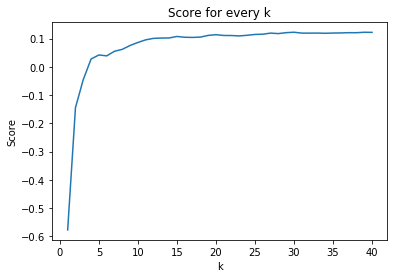

29


In [15]:
from sklearn.neighbors import KNeighborsRegressor

# Scaling the data and making training and test datasets:

df_income = df_health[(df_health.income > 0) & (df_health.income < 100000)]

columns = ['body_code', 'age']

scaler = MinMaxScaler()
scaler.fit(df_income[columns])

lin_features = pd.DataFrame(scaler.transform(df_income[columns]), columns=columns)

train_X, test_X, train_y, test_y = train_test_split(lin_features[columns], 
                                                    df_income['income'], test_size=0.2, 
                                                    random_state=7)

# Finding the optimal k:

features = columns
scores = []

for i in range(1, 41):
    
    regressor = KNeighborsRegressor(n_neighbors=i, weights='distance')
    regressor.fit(train_X[features], train_y)
    
    scores.append(regressor.score(test_X[features], test_y))

plt.plot(range(1, 41), scores)
plt.xlabel('k')
plt.ylabel('Score')
plt.title('Score for every k')
plt.show()

ideal_k = scores.index(max(scores))

print(ideal_k)

Regressor score:0.10429613130782422


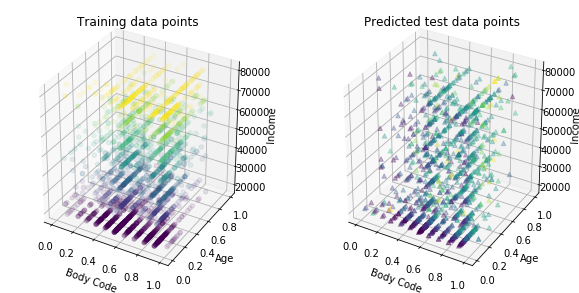

In [21]:
# Fitting the regressor to test data:

k = 13

regressor = KNeighborsRegressor(n_neighbors=k, weights='distance')

regressor.fit(train_X, train_y)

test_predictions = regressor.predict(test_X)

print('Regressor score:' + str(regressor.score(test_X, test_y)))

# Plotting the predicted data against the known data:

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(train_X.iloc[:,0], train_X.iloc[:,1], train_y, alpha=0.1, c=train_y, marker='o')
ax1.set_xlabel('Body Code')
ax1.set_ylabel('Age')
ax1.set_zlabel('Income')
ax1.set_title('Training data points')

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(test_X.iloc[:,0], test_X.iloc[:,1], test_y, alpha=0.3, c=test_predictions, marker='^')
ax2.set_xlabel('Body Code')
ax2.set_ylabel('Age')
ax2.set_zlabel('Income')
ax2.set_title('Predicted test data points')

plt.show()

Well, our KNeighbors regressor isn't too great at prediciting how much someone makes based on how they look or how old they are. The colors at the different Z-positions in the right graph should match the colors from the left graph.

What about a Linear Regressor?

In [22]:
from sklearn.linear_model import LinearRegression

# Creating the training and test datasets:

train_X, test_X, train_y, test_y = train_test_split(lin_features[columns], df_income['income'],
                                                    test_size=0.3, random_state=7)

Regressor score:0.15555859380361925


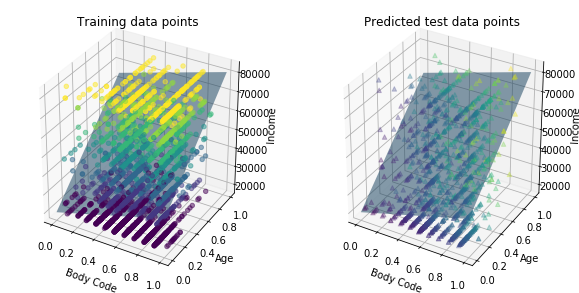

In [23]:
# Creating the model:

model = LinearRegression()
model.fit(train_X, train_y)

test_predictions = model.predict(test_X)

print('Regressor score:' + str(model.score(test_X, test_y)))

#Plotting the model's prediction data against the known smoke_code:

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(train_X.iloc[:,0], train_X.iloc[:,1], train_y, alpha=0.5, c=train_y)
ax1.plot_surface(np.array([[0, 0], [1, 1]]),
                    np.array([[0, 1], [0, 1]]),
                    model.predict(np.array([[0, 0, 1, 1],
                                            [0, 1, 0, 1]]).T).reshape((2, 2)), alpha=0.5)
ax1.set_xlabel('Body Code')
ax1.set_ylabel('Age')
ax1.set_zlabel('Income')
ax1.set_title('Training data points')

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(test_X.iloc[:,0], test_X.iloc[:,1], test_y, alpha=0.3, c=test_predictions, marker='^')
ax2.plot_surface(np.array([[0, 0], [1, 1]]),
                    np.array([[0, 1], [0, 1]]),
                    model.predict(np.array([[0, 0, 1, 1],
                                            [0, 1, 0, 1]]).T).reshape((2, 2)), alpha=0.5)
ax2.set_xlabel('Body Code')
ax2.set_ylabel('Age')
ax2.set_zlabel('Income')
ax2.set_title('Predicted test data points')

plt.show()

The linear regressor may be doing slightly better than my KNeighbors regressor, and computes much faster since you don't need to determine optimal k for the model.

But, I suspected that the regressors were primarily using age as the primary predictive feature, so I created a regressor with just age to test this.

Regressor score:0.13010752356839683


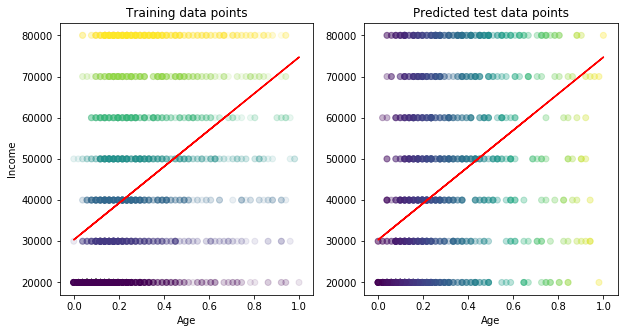

In [24]:
# Only using age as a feature:

columns = ['age']

scaler = MinMaxScaler()
scaler.fit(df_income[columns])

lin_features = pd.DataFrame(scaler.transform(df_income[columns]), columns=columns)

train_X, test_X, train_y, test_y = train_test_split(lin_features[columns], df_income['income'],
                                                    test_size=0.3, random_state=7)

# Creating the model:

model = LinearRegression()
model.fit(train_X, train_y)

model_standard = model.predict(train_X)
prediction = model.predict(test_X)

print('Regressor score:' + str(model.score(test_X, test_y)))

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(121)
ax1.scatter(train_X, train_y, c=train_y, alpha=0.1)
ax1.plot(train_X, model_standard, c='red')
ax1.set_xlabel('Age')
ax1.set_ylabel('Income')
ax1.set_title('Training data points')

ax2 = fig.add_subplot(122)
ax2.scatter(test_X, test_y, c=prediction, alpha=0.3)
ax2.plot(train_X, model_standard, c='red')
ax2.set_xlabel('Age')
ax2.set_title('Predicted test data points')

plt.show()

Age doesn't seem to perform any better than using age and body_type. If anything, it performs slightly worse. So our original regressor was the better way of predicting income.

These data may reflect actual population demographics, but it's also possible that the self-reported nature of these features leads to an artificial bias. For example: drinking "socially" may be over-reported in the context of a dating questionnaire so as not to put off any potential matches who may find drinking more heavily to be an undesirable trait.